# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 6. Нейросети в обработке текста

### Практическое задание

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech


2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

### Решение

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from string import punctuation
from stop_words import get_stop_words
# from pymorphy2 import MorphAnalyzer
import re

from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


#### Настройки проекта

In [2]:
# Путь к данным.
PATH_DATA = r'train.csv'

# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Настройки обработки текста.
MAX_WORDS = 2000
MAX_LEN = 20
NUM_CLASSES = 1

#### Подготовка данных

In [3]:
# Загрузка данных.
df = pd.read_csv(PATH_DATA, index_col='id')

In [4]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [5]:
# Вывод размерности датасета.
df.shape

(31962, 2)

In [6]:
# Инициализация инструмента лемматизации.
lemmatizer = WordNetLemmatizer()

In [7]:
# Проверка: лемматизация слов.
print(
    f"cars\t->\t{lemmatizer.lemmatize('cars')}" \
    f"\ngoes\t->\t{lemmatizer.lemmatize('goes')}"
)

cars	->	car
goes	->	go


In [8]:
# Функция для подготовки текста:
def text_preprocessing(text):
    # удаление никнеймов,
    text = text.replace('@user ', '')
    
    # удаление прочих небуквенных и числовых символов,
    for symbol in punctuation:
        text = text.replace(symbol, '')
    
    # приведение текста к нижнему регистру,
    text = text.lower()
    
    # лемматизация слов в тексте,
    text = [*map(lemmatizer.lemmatize, text.split())]
    
    # исключение некорректных слов и стоп-слов,
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in get_stop_words(language='en')]
    
    # соединение массива в строку.
    text = " ".join(text)
    
    return text

In [9]:
%%time


# Предобработка твитов.
df['tweet_preprocessed'] = df['tweet'].apply(lambda text: text_preprocessing(text))

CPU times: total: 1.53 s
Wall time: 1.53 s


In [10]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet,tweet_preprocessed
id,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love u take u time
5,0,factsguide: society now #motivation,factsguide society now motivation


In [11]:
# Загрузка всех слов из твитов.
words = " ".join(df['tweet_preprocessed'])
words = words.split()

In [12]:
# Проверка: вывод первых десяти слов и общего количества слов.
words[:10], len(words)

(['father',
  'dysfunctional',
  'selfish',
  'drag',
  'kid',
  'dysfunction',
  'run',
  'thanks',
  'lyft',
  'credit'],
 253334)

In [13]:
# Определение частоты каждого слова.
top_words = FreqDist(words)

In [14]:
# Проверка: вывод наиболее частых слов и количества уникальных слов во всех твитах.
top_words, len(top_words)

(FreqDist({'love': 2695, 'day': 2679, 'happy': 1662, 'u': 1645, 'amp': 1582, 'just': 1346, 'will': 1271, 'time': 1219, 'life': 1189, 'im': 1139, ...}),
 37683)

In [15]:
# Формирование словаря наиболее частых слов.
dict_top_words = dict((pair[0], pair[1]) for pair in top_words.most_common(MAX_WORDS - 1))

In [16]:
# Формирование списка наиболее частых слов.
list_top_words = [*dict_top_words.keys()]

In [17]:
# Проверка: вывод длины словаря и списка.
len(dict_top_words), len(list_top_words)

(1999, 1999)

In [18]:
# Функция для преобразования текста в числовую последовательность:
def text_to_sequence(text, maxlen=MAX_LEN):
    # разбиение строки на массив,
    text = text.split()
    
    # фильтрация, останутся только наиболее частые слова,
    text = [top_words[word] for word in text if word in list_top_words]
    
    # выбор первых 20 слов,
    text = text[:20]
    
    # дополнение нулями, если не набралось 20 слов.
    text = text + [0] * (MAX_LEN - len(text))
    
    return text

In [19]:
# Твиты до токенизации.
df['tweet_preprocessed'].head()

id
1    father dysfunctional selfish drag kid dysfunct...
2    thanks lyft credit cant use cause dont offer w...
3                                       bihday majesty
4                             model love u take u time
5                    factsguide society now motivation
Name: tweet_preprocessed, dtype: object

In [20]:
# Твиты после токенизации.
df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))

id
1    [903, 257, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [301, 802, 114, 78, 718, 36, 0, 0, 0, 0, 0, 0,...
3    [824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
4    [376, 2695, 1645, 672, 1645, 1219, 0, 0, 0, 0,...
5    [30, 975, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: tweet_preprocessed, dtype: object

In [21]:
# Вывод токенов первого объекта.
df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))[1]

[903, 257, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
# Вывод длины токенов первого объекта.
len(df['tweet_preprocessed'].head().apply(lambda x: text_to_sequence(x))[1])

20

In [23]:
%%time


# Токенизация всех твитов.
df['tweet_tokenized'] = df['tweet_preprocessed'].apply(lambda x: text_to_sequence(x))

CPU times: total: 2.39 s
Wall time: 2.4 s


In [24]:
# Проверка: вывод вервых пяти строк.
df.head()

,label,tweet,tweet_preprocessed,tweet_tokenized
id,,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,"[903, 257, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...,"[301, 802, 114, 78, 718, 36, 0, 0, 0, 0, 0, 0,..."
3,0,bihday your majesty,bihday majesty,"[824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,0,#model i love u take with u all the time in ...,model love u take u time,"[376, 2695, 1645, 672, 1645, 1219, 0, 0, 0, 0,..."
5,0,factsguide: society now #motivation,factsguide society now motivation,"[30, 975, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [25]:
# Класс датасета.
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [26]:
# Разбиение данных на обучающую и тестовую выборки.
df_train, df_test = train_test_split(df, test_size=0.25, random_state=GLOBAL__RANDOM_STATE)

# Проверка: вывод размерностей.
df_train.shape, df_test.shape

((23971, 4), (7991, 4))

In [27]:
# Формирование обучающих датасета и загрузчика.
train_dataset = DataWrapper(np.array([*df_train['tweet_tokenized'].values]), df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Формирование тестовых датасета и загрузчика.
val_dataset = DataWrapper(np.array([*df_test['tweet_tokenized'].values]), df_test['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [28]:
# Проверка обучающего загрузчика.
for x, y in train_loader:
    print(f'Размерность тензора объекта:\t{x[0].shape}')
    print(f'Тензор:\n\t{x[0]}')
    print(f'\nРазмерность тензора ответов в батче:\t{y.shape}')
    print(f'Первый ответ в батче:\t{y[0]}')
    break

Размерность тензора объекта:	torch.Size([20])
Тензор:
	tensor([ 270,  267,  126,  267,  143,   57,   54, 1139,   64,  238,   27,  119,
           0,    0,    0,    0,    0,    0,    0,    0])

Размерность тензора ответов в батче:	torch.Size([512])
Первый ответ в батче:	0


#### Построение модели

In [29]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
#         Дебажить: не хватает размерности 2000!
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(2700, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [30]:
# Инициализация модели.
model = Net(vocab_size=MAX_WORDS)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
# Вывод структуры и количества обучаемых параметров модели.
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2700, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 436097


In [32]:
# Оптимизатор и функция потерь.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [33]:
%%time


# Обучение и валидация модели на десяти эпохах.
epochs = 10

model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10]. Step [47/47]. Loss: 0.199. Acc: 0.929. Test loss: 0.041. Test acc: 0.934
Epoch [2/10]. Step [47/47]. Loss: 0.198. Acc: 0.935. Test loss: 0.103. Test acc: 0.943
Epoch [3/10]. Step [47/47]. Loss: 0.161. Acc: 0.945. Test loss: 0.071. Test acc: 0.944
Epoch [4/10]. Step [47/47]. Loss: 0.105. Acc: 0.955. Test loss: 0.084. Test acc: 0.942
Epoch [5/10]. Step [47/47]. Loss: 0.151. Acc: 0.961. Test loss: 0.019. Test acc: 0.946
Epoch [6/10]. Step [47/47]. Loss: 0.085. Acc: 0.974. Test loss: 0.093. Test acc: 0.941
Epoch [7/10]. Step [47/47]. Loss: 0.054. Acc: 0.974. Test loss: 0.014. Test acc: 0.944
Epoch [8/10]. Step [47/47]. Loss: 0.079. Acc: 0.978. Test loss: 0.019. Test acc: 0.940
Epoch [9/10]. Step [47/47]. Loss: 0.060. Acc: 0.982. Test loss: 0.174. Test acc: 0.934
Epoch [10/10]. Step [47/47]. Loss: 0.064. Acc: 0.983. Test loss: 0.001. Test acc: 0.941
Training is finished!
CPU times: total: 2min 43s
Wall time: 21.4 s


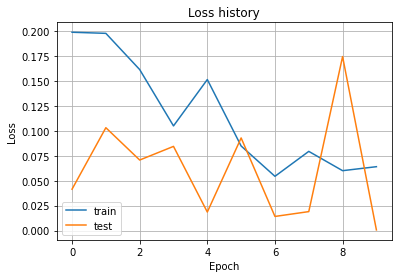

In [34]:
import matplotlib.pyplot as plt


# Визуализация функций потерь на обучающей и тестовой выборках.
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();